In [2]:
!pip install open-clip-torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
  

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


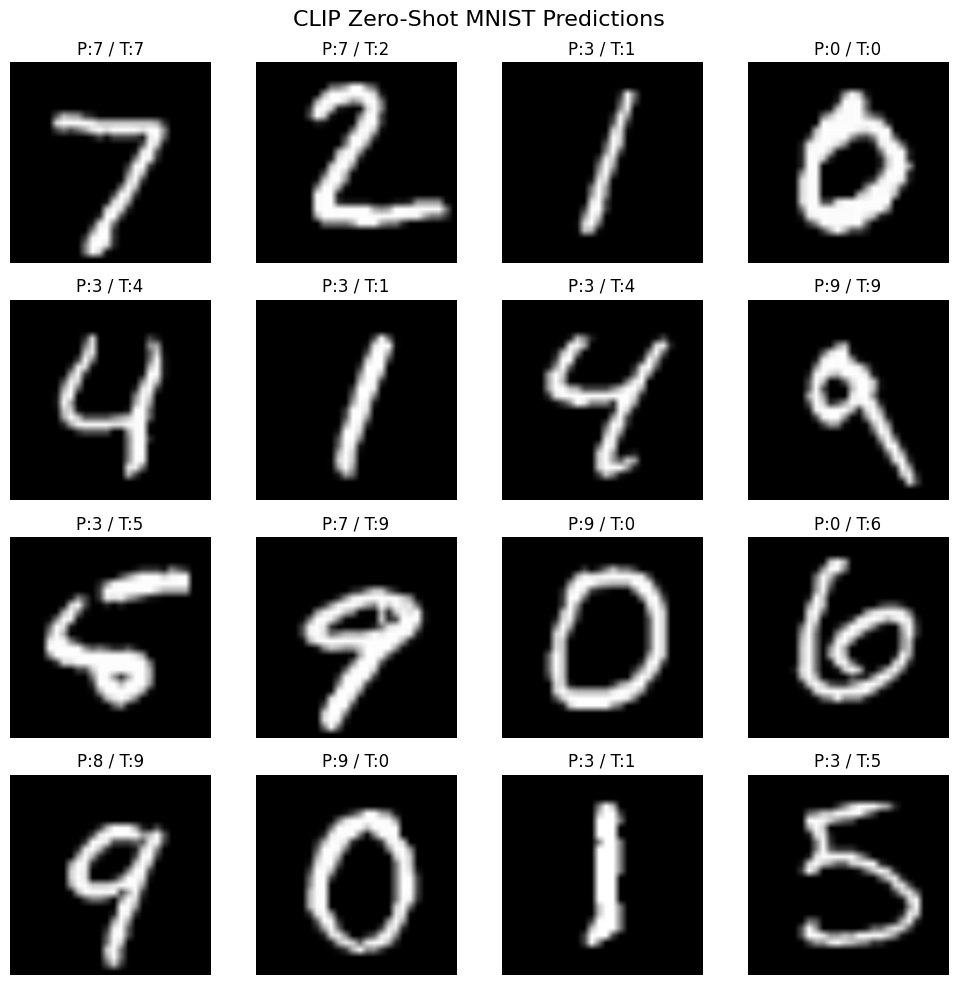

In [1]:
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Resize, Grayscale
import matplotlib.pyplot as plt
from torchvision import transforms

import open_clip

# Load CLIP model (ViT-B/32)
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
tokenizer = open_clip.get_tokenizer('ViT-B-32')
model.eval().cuda()

# Custom transform: Convert to RGB + Resize
transform = Compose([Resize((224, 224)), Grayscale(num_output_channels=3), ToTensor()])

# Load a small subset of MNIST test set
mnist = MNIST(root='./data', train=False, download=True, transform=transform)
images, labels = zip(*[mnist[i] for i in range(16)])

# Prepare text prompts
text_prompts = [f"A photo of the digit {i}" for i in range(10)]
text_tokens = tokenizer(text_prompts).cuda()

# Preprocess images for CLIP
image_inputs = torch.stack([preprocess(transforms.ToPILImage()(img)) for img in images]).cuda()

# CLIP encode
with torch.no_grad():
    image_features = model.encode_image(image_inputs)
    text_features = model.encode_text(text_tokens)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    logits = image_features @ text_features.T
    predictions = logits.argmax(dim=-1).cpu()

# Plot results
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0), cmap='gray')
    plt.title(f"P:{predictions[i].item()} / T:{labels[i]}")
    plt.axis("off")
plt.suptitle("CLIP Zero-Shot MNIST Predictions", fontsize=16)
plt.tight_layout()
plt.show()
